# AML - VOC 2012

Volpato Mattia 866316

## Imports and utility

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from tqdm import tqdm
import random

from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
ROOT_DIR = '/content/drive/MyDrive/'
TRAIN_IMAGES_DIR = ROOT_DIR + 'AML/project/trainval/JPEGImages/'
TRAIN_ANNOTATIONS_DIR = ROOT_DIR + 'AML/project/trainval/dataset/'
TEST_BASE_DIR = ROOT_DIR + 'AML/project/test/'

TRAIN_IMAGES_DIR, TRAIN_ANNOTATIONS_DIR, TEST_BASE_DIR

('/content/drive/MyDrive/AML/project/trainval/JPEGImages/',
 '/content/drive/MyDrive/AML/project/trainval/dataset/',
 '/content/drive/MyDrive/AML/project/test/')

In [ ]:
SINGLE_CLASS_DATASET_FILENAME = 'dataset_single_class.csv'
MULTICLASS_DATASET_FILENAME = 'dataset_multiclass.csv'

In [ ]:
RANDOM_STATE = 17
N_IMAGES_TO_SHOW = 10
EPSILON = 0.05
N_CLASSES = 20

TRAIN_SIZE, VALIDATION_SIZE = 0.8, 0.2
assert abs(TRAIN_SIZE + VALIDATION_SIZE- 1) < 1e-6, "Train and validation sizes must sum to 1"

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
keras.utils.set_random_seed(RANDOM_STATE)

In [ ]:
RESNET_NAME = 'resnet'
RESNET_RESIZE = (224, 224)

ALEXNET_NAME = 'alexnet'
ALEXNET_RESIZE = (227, 227)

In [ ]:
def plot_history(history) -> None:
  fig, axis = plt.subplots(1, 2, figsize=(15, 5))
  fig.tight_layout()

  train_accuracy = history.history['accuracy']
  train_loss = history.history['loss']
  val_accuracy = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  axis[0].set_title('Loss')
  axis[0].set_xlabel('Epochs')
  axis[0].set_ylabel('Loss')
  axis[0].plot(train_loss, label='Training Loss')
  axis[0].plot(val_loss, label='Validation Loss')
  axis[0].legend()

  axis[1].set_title('Accuracy')
  axis[1].set_xlabel('Epochs')
  axis[1].set_ylabel('Accuracy')
  axis[1].plot(train_accuracy, label='Training Accuracy')
  axis[1].plot(val_accuracy, label='Validation Accuracy')
  axis[1].legend()

  plt.show()

## Preprocessing

In [ ]:
df = pd.read_csv(TRAIN_ANNOTATIONS_DIR + SINGLE_CLASS_DATASET_FILENAME)
df.head()

,file,class_id,class
0,2008_000021,1,aeroplane
1,2008_000033,1,aeroplane
2,2008_000037,1,aeroplane
3,2008_000064,1,aeroplane
4,2008_000151,1,aeroplane


One-hot encoding:

In [ ]:
def one_hot_encode(label, num_classes):
    one_hot = np.zeros(num_classes)
    one_hot[label - 1] = 1
    return one_hot

In [ ]:
df["one_hot_class_id"] = df["class_id"].apply(lambda x: one_hot_encode(x, N_CLASSES))
df

,file,class_id,class,one_hot_class_id
0,2008_000021,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2008_000033,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2008_000037,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2008_000064,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2008_000151,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
7562,2011_002292,20,tvmonitor,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7563,2011_002514,20,tvmonitor,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7564,2011_002879,20,tvmonitor,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7565,2011_002942,20,tvmonitor,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Some images:

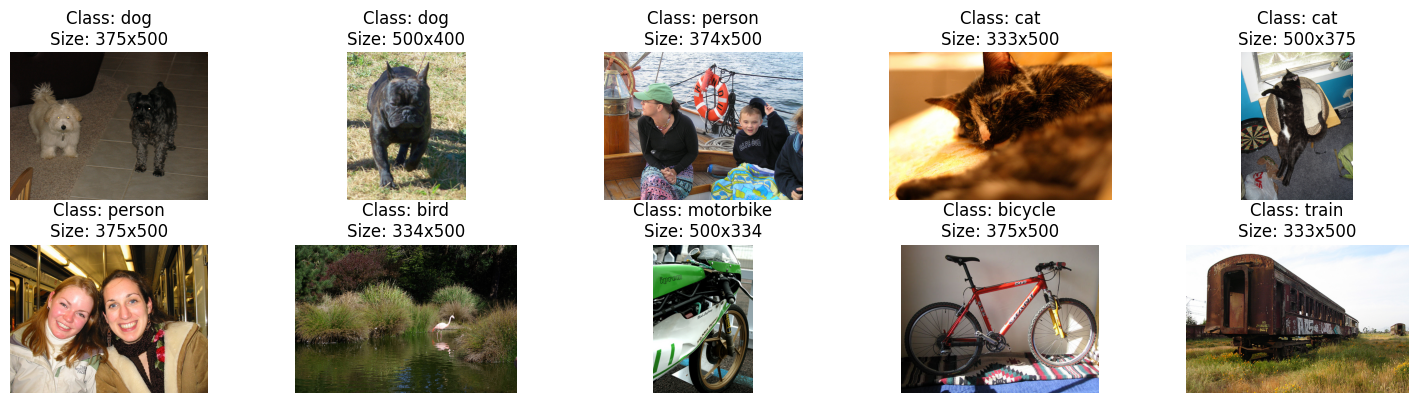

In [ ]:
file_rows = df.sample(N_IMAGES_TO_SHOW, random_state=RANDOM_STATE)

images = [np.array(Image.open(f"{TRAIN_IMAGES_DIR}{file}.jpg")) for file in file_rows["file"]]
classes = [c for c in file_rows["class"]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):  # Usa axes.flat per iterare su tutte le sottotrama
    axis.imshow(images[i], cmap='gray')
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'Class: {classes[i]}\nSize: {image_size[0]}x{image_size[1]}')

plt.show()

Images loading and preprocessing:

In [ ]:
df["filepath"] = df["file"].apply(lambda x: f"{TRAIN_IMAGES_DIR}{x}.jpg")
df.head()

,file,class_id,class,one_hot_class_id,filepath
0,2008_000021,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/AML/project/trainval/JP...
1,2008_000033,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/AML/project/trainval/JP...
2,2008_000037,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/AML/project/trainval/JP...
3,2008_000064,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/AML/project/trainval/JP...
4,2008_000151,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/AML/project/trainval/JP...


In [ ]:
labels_array = np.stack(df["one_hot_class_id"].values)
labels_tensor = tf.convert_to_tensor(labels_array, dtype=tf.float32)
labels_tensor

<tf.Tensor: shape=(7567, 20), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

In [ ]:
def load_and_preprocess_image(file_path, label, model_preprocessing:str=RESNET_NAME):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decodifica in formato RGB

    resize = None
    mean = None
    if model_preprocessing == RESNET_NAME:
        resize = RESNET_RESIZE
    elif model_preprocessing == ALEXNET_NAME:
        resize = ALEXNET_RESIZE
    else:
        raise ValueError(f"Unknown model preprocessing: {model_preprocessing}")

    image = tf.image.resize(image, (64, 64))
    image /= 255.0

    return image, label

In [ ]:
image_dataset = tf.data.Dataset.from_tensor_slices((df["filepath"], labels_tensor))
image_dataset = image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
image_dataset = image_dataset.shuffle(buffer_size=len(image_dataset), seed=RANDOM_STATE)    # Shuffle so that images are no more ordered by label (for minibatches)

image_dataset

<_ShuffleDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None))>

## Base model

In [ ]:
def create_base_model(input_shape=(64, 64, 3), num_classes=N_CLASSES, dropout_rate=0.3):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dropout(0.2),

        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=EPSILON),
                  metrics=['accuracy'])

    return model

model = create_base_model(input_shape=(64, 64, 3), num_classes=20)
model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_99 (Dropout)        (None, 64, 64, 3)         0         
                                                                 
 conv2d_69 (Conv2D)          (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_100 (Dropout)       (None, 30, 30, 16)        0         
                                                                 
 conv2d_70 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                               

In [ ]:
BATCH_SIZE = 64

In [ ]:
image_dataset_len = len(df)
train_len = int(TRAIN_SIZE * image_dataset_len)

train_dataset = image_dataset.take(train_len)
val_dataset = image_dataset.skip(train_len)

print(f"Number of training examples: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Number of validation examples: {tf.data.experimental.cardinality(val_dataset)}")

Number of training examples: 6053
Number of validation examples: 1514


In [ ]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
early_stopping

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
95/95 [==============================] - 44s 334ms/step - loss: 2.8162 - accuracy: 0.1409 - val_loss: 2.8451 - val_accuracy: 0.1579
Epoch 2/200
95/95 [==============================] - 41s 320ms/step - loss: 2.7462 - accuracy: 0.1444 - val_loss: 2.7444 - val_accuracy: 0.1592
Epoch 3/200
95/95 [==============================] - 42s 325ms/step - loss: 2.6712 - accuracy: 0.1629 - val_loss: 2.7095 - val_accuracy: 0.1460
Epoch 4/200
95/95 [==============================] - 40s 312ms/step - loss: 2.6210 - accuracy: 0.1755 - val_loss: 2.6158 - val_accuracy: 0.1737
Epoch 5/200
95/95 [==============================] - 41s 327ms/step - loss: 2.5609 - accuracy: 0.1849 - val_loss: 2.5896 - val_accuracy: 0.1790
Epoch 6/200
95/95 [==============================] - 43s 341ms/step - loss: 2.5139 - accuracy: 0.2009 - val_loss: 2.6558 - val_accuracy: 0.1645
Epoch 7/200
95/95 [==============================] - 42s 331ms/step - loss: 2.4804 - accuracy: 0.2206 - val_loss: 2.6613 - val_accuracy:

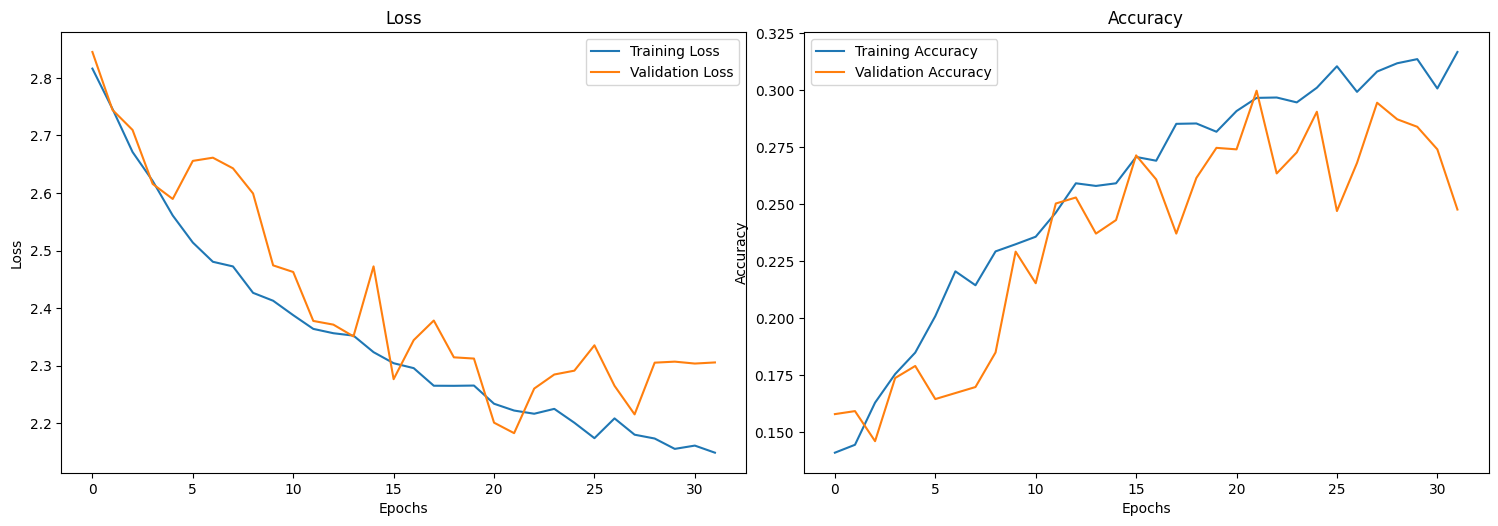

In [ ]:
plot_history(history)

## Model with more parameters

In [ ]:
def create_model_1(input_shape=(64, 64, 3), num_classes=N_CLASSES, dropout_rate=0.3):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dropout(0.2),

        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(32, (5, 5), activation='relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=EPSILON),
                  metrics=['accuracy'])

    return model

model_1 = create_model_1(input_shape=(64, 64, 3), num_classes=20)
model_1.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_185 (Dropout)       (None, 64, 64, 3)         0         
                                                                 
 conv2d_124 (Conv2D)         (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d_65 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_186 (Dropout)       (None, 30, 30, 16)        0         
                                                                 
 conv2d_125 (Conv2D)         (None, 26, 26, 16)        6416      
                                                                 
 max_pooling2d_66 (MaxPooli  (None, 13, 13, 16)        0         
 ng2D)                                               

In [ ]:
BATCH_SIZE = 64

In [ ]:
image_dataset_len = len(df)
train_len = int(TRAIN_SIZE * image_dataset_len)

train_dataset = image_dataset.take(train_len)
val_dataset = image_dataset.skip(train_len)

print(f"Number of training examples: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Number of validation examples: {tf.data.experimental.cardinality(val_dataset)}")

Number of training examples: 6053
Number of validation examples: 1514


In [ ]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
early_stopping

In [ ]:
history_1 = model_1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
95/95 [==============================] - 51s 399ms/step - loss: 2.8017 - accuracy: 0.1265 - val_loss: 2.7284 - val_accuracy: 0.1592
Epoch 2/200
95/95 [==============================] - 48s 385ms/step - loss: 2.7411 - accuracy: 0.1479 - val_loss: 2.6889 - val_accuracy: 0.1678
Epoch 3/200
95/95 [==============================] - 45s 372ms/step - loss: 2.7114 - accuracy: 0.1517 - val_loss: 2.6060 - val_accuracy: 0.1691
Epoch 4/200
95/95 [==============================] - 48s 382ms/step - loss: 2.6390 - accuracy: 0.1682 - val_loss: 2.6267 - val_accuracy: 0.1777
Epoch 5/200
95/95 [==============================] - 48s 384ms/step - loss: 2.5701 - accuracy: 0.1814 - val_loss: 2.4883 - val_accuracy: 0.2041
Epoch 6/200
95/95 [==============================] - 46s 381ms/step - loss: 2.5420 - accuracy: 0.1867 - val_loss: 2.5414 - val_accuracy: 0.1935
Epoch 7/200
95/95 [==============================] - 49s 392ms/step - loss: 2.5094 - accuracy: 0.1963 - val_loss: 2.5173 - val_accuracy:

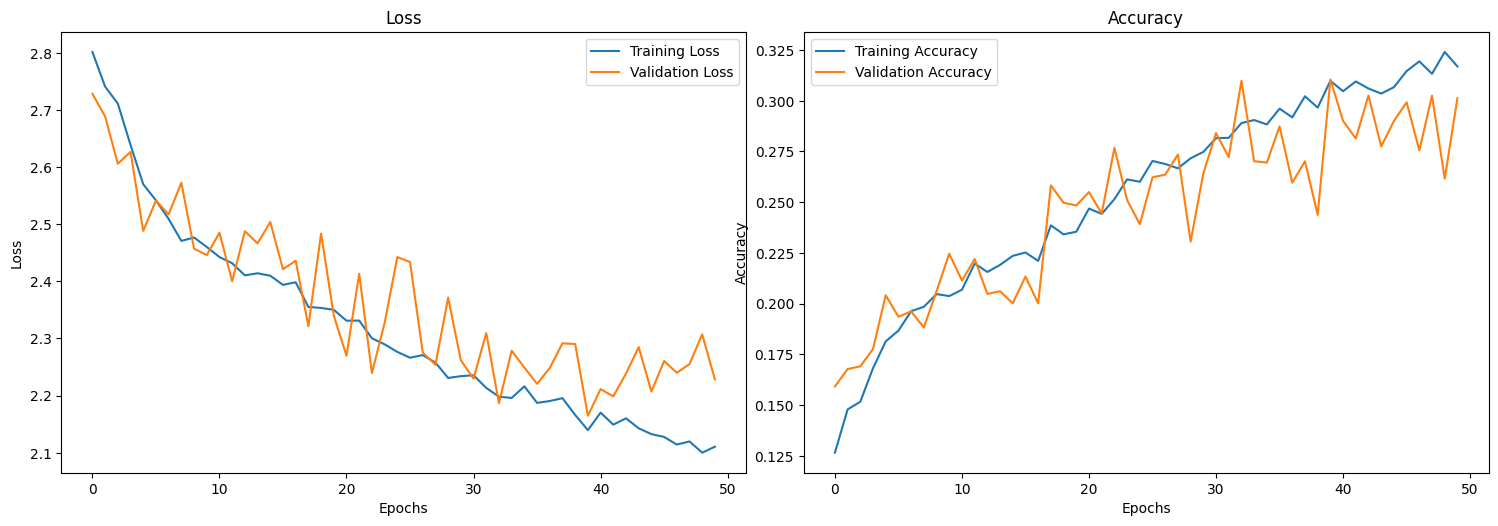

In [ ]:
plot_history(history_1)